<a href="https://colab.research.google.com/github/peterchang0414/randomized_priors/blob/main/randomized_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Ensembles with Randomized Prior Functions 

This notebook illustrates a way to improve predictive uncertainty using deep ensembles. It is based on this paper:

I. Osband, J. Aslanides, and A. Cassirer, “Randomized prior functions for deep reinforcement learning,” in NIPS, Jun. 2018 [Online]. Available: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf. 

The original  Tensorflow demo is from  https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

This JAX translation is by Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [145]:
!pip -q install flax

In [146]:
%matplotlib inline

from functools import partial

import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
from jax import jit
from jax.nn.initializers import glorot_normal
import flax
import flax.linen as nn
from flax.training import train_state

# 1. Simple Example

We will use a 1d synthetic regression dataset from this paper

C. Blundell, J. Cornebise, K. Kavukcuoglu, and D. Wierstra, “Weight Uncertainty in Neural Networks,” in ICML, May 2015 [Online]. Available: http://arxiv.org/abs/1505.05424


$$
\begin{align}
y &= x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, 0.02) \\
x &\sim \mathcal{U}(0.0, 0.5)
\end{align}
$$



In [147]:
# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(key, x):
    epsilons = jax.random.normal(key, shape=(3,))*0.02
    return (x + 0.3*jnp.sin(2*jnp.pi*(x+epsilons[0])) + 
            0.3*jnp.sin(4*jnp.pi*(x+epsilons[1])) + epsilons[2])

# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

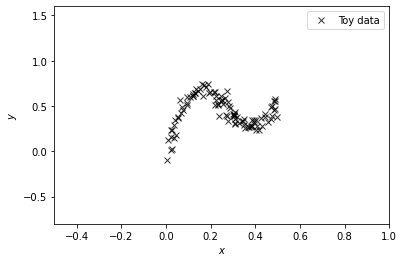

In [148]:
# Plot the generated data
plt.figure() #figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
#plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.8,1.6)
plt.legend();
plt.show()

#2. Randomized Prior Functions

The core idea is to represent each ensemble member $g_i$ by
$$g_i(x; \theta_i) = t_i(x; \theta_i) + \beta p_i(x)$$,
where $t_i$ is a trainable network, and $p_i$ is a fixed, but random, prior network.

In [149]:
# Prior and trainable networks have the same architecture
class GenericNet(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        dense = partial(nn.Dense, kernel_init=glorot_normal())
        return nn.Sequential([dense(16), 
                              nn.elu, 
                              dense(16), 
                              nn.elu, 
                              dense(1)])(x)

# Model that combines prior and trainable nets
class Model(nn.Module):
    prior: GenericNet
    trainable: GenericNet
    beta: float

    @nn.compact
    def __call__(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta*x1 + x2

In [150]:
def create_train_state(key, X, beta, lr):
    key, _ = jax.random.split(key)
    model = Model(prior=GenericNet(), trainable=GenericNet(), beta=beta)
    params = model.init(key, X)['params']
    p_params, t_params = params['prior'], params['trainable']
    opt = optax.adam(learning_rate=lr)
    return p_params, train_state.TrainState.create(apply_fn=model.apply, 
                                                    params=t_params, tx=opt)

@jax.jit
def train_epoch(prior, train_state, X, Y, beta):
    def loss_fn(params):
        model = Model(prior=GenericNet(), trainable=GenericNet(), beta=beta)
        Yhat = model.apply({'params': {'prior': prior, 'trainable': params}}, X)
        loss = jnp.mean((Yhat - Y)**2)
        return loss
    Yhats, grads = jax.value_and_grad(loss_fn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state

def train(key, X, Y, beta, lr, epochs):
    p_params, train_state = create_train_state(key, X, beta, lr)
    for epoch in range(1, epochs + 1):
        train_state = train_epoch(p_params, train_state, X, Y, beta)
    return {'prior': p_params, 'trainable': train_state.params}

In [151]:
beta = 3
epochs = 2000
learning_rate = 0.03
params = train(jax.random.PRNGKey(0), X, Y, beta, learning_rate, epochs)

In [152]:
# Prediction function to be resued in Part 3
def get_predictions(X, params, beta):
    p_param, t_param = params['prior'], params['trainable']
    generic = GenericNet()
    model = Model(prior=GenericNet(), trainable=GenericNet(), beta=beta)
    Y_prior = generic.apply({'params': p_param}, X)
    Y_trainable = generic.apply({'params': t_param}, X)
    Y_model = model.apply({'params': params}, X)
    return Y_prior, Y_trainable, Y_model

In [153]:
Y_prior, Y_trainable, Y_model = get_predictions(x_grid, params, 3)

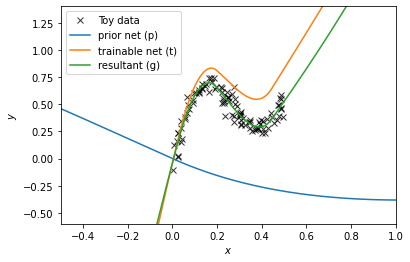

In [154]:
# Plot the results
plt.figure() #figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.plot(x_grid, 3*Y_prior, label='prior net (p)')
plt.plot(x_grid, Y_trainable, label='trainable net (t)')
plt.plot(x_grid, Y_model, label='resultant (g)')
#plt.title('Predictions of the prior network: random function')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.6,1.4)
plt.legend();

plt.savefig('randomized_priors_single_model.pdf')  
plt.savefig('randomized_priors_single_model.png') 

plt.show()

# 3. Bootstrapped Ensembles

To implement bootstrapping using JAX, we generate a random map from seed values to dataset index values: $\{\text{seed}, \text{seed}+1 \dots, \text{seed}+99\} \to \{ 0, 1, \dots, 99 \}$ by utilizing ``` jax.random.randint ```  using a randomly-generated seed. We assume the random key space is large enough that we need not be concerned with generating overlapping seed ranges.

In [155]:
def generate_bootstrap(key, size):
  seed, _ = jax.random.split(key)
  return [jax.random.randint(seed+i, (), 0, size) for i in range(size)]

In [156]:
# An ensemble model with randomized prior nets
# make_batch() function borrowed from https://github.com/google/jax/issues/7430
def build_ensemble(n_estimators, X, Y, beta, lr, epochs, bootstrap):
    def make_batch(params):
        return jax.tree_map(lambda *a: jnp.stack(a), *params)
    ensemble = []
    for i in range(n_estimators):
        key, subkey = jax.random.split(jax.random.PRNGKey(i))
        if bootstrap:
            sample = jnp.array(generate_bootstrap(key, X.shape[0]))
            X_b, Y_b = jnp.take(X, sample), jnp.take(Y, sample)
            X_b, Y_b = X.reshape(-1,1), Y.reshape(-1,1)
            key, _ = jax.random.split(subkey)
        else:
            X_b, Y_b = X, Y
        ensemble.append(train(key, X_b, Y_b, beta, lr, epochs))
    return make_batch(ensemble)

In [157]:
# Array of predictions for each model in trained ensemble
def get_ensemble_predictions(n_estimators, X, Y, X_new, beta, lr, epochs, 
                             bootstrap=True):
    ensemble = build_ensemble(n_estimators, X, Y, beta, lr, epochs, bootstrap)
    return jax.vmap(get_predictions, in_axes=(None, 0, None))(X_new, ensemble, 
                                                              beta)

In [160]:
# Compute prediction values for each net in ensemble
n_estimators = 9
beta = 3
learning_rate = 0.03
epochs = 2000
p_grid, t_grid, y_grid = get_ensemble_predictions(n_estimators, X, Y, x_grid, 
                                                  beta, learning_rate, epochs)

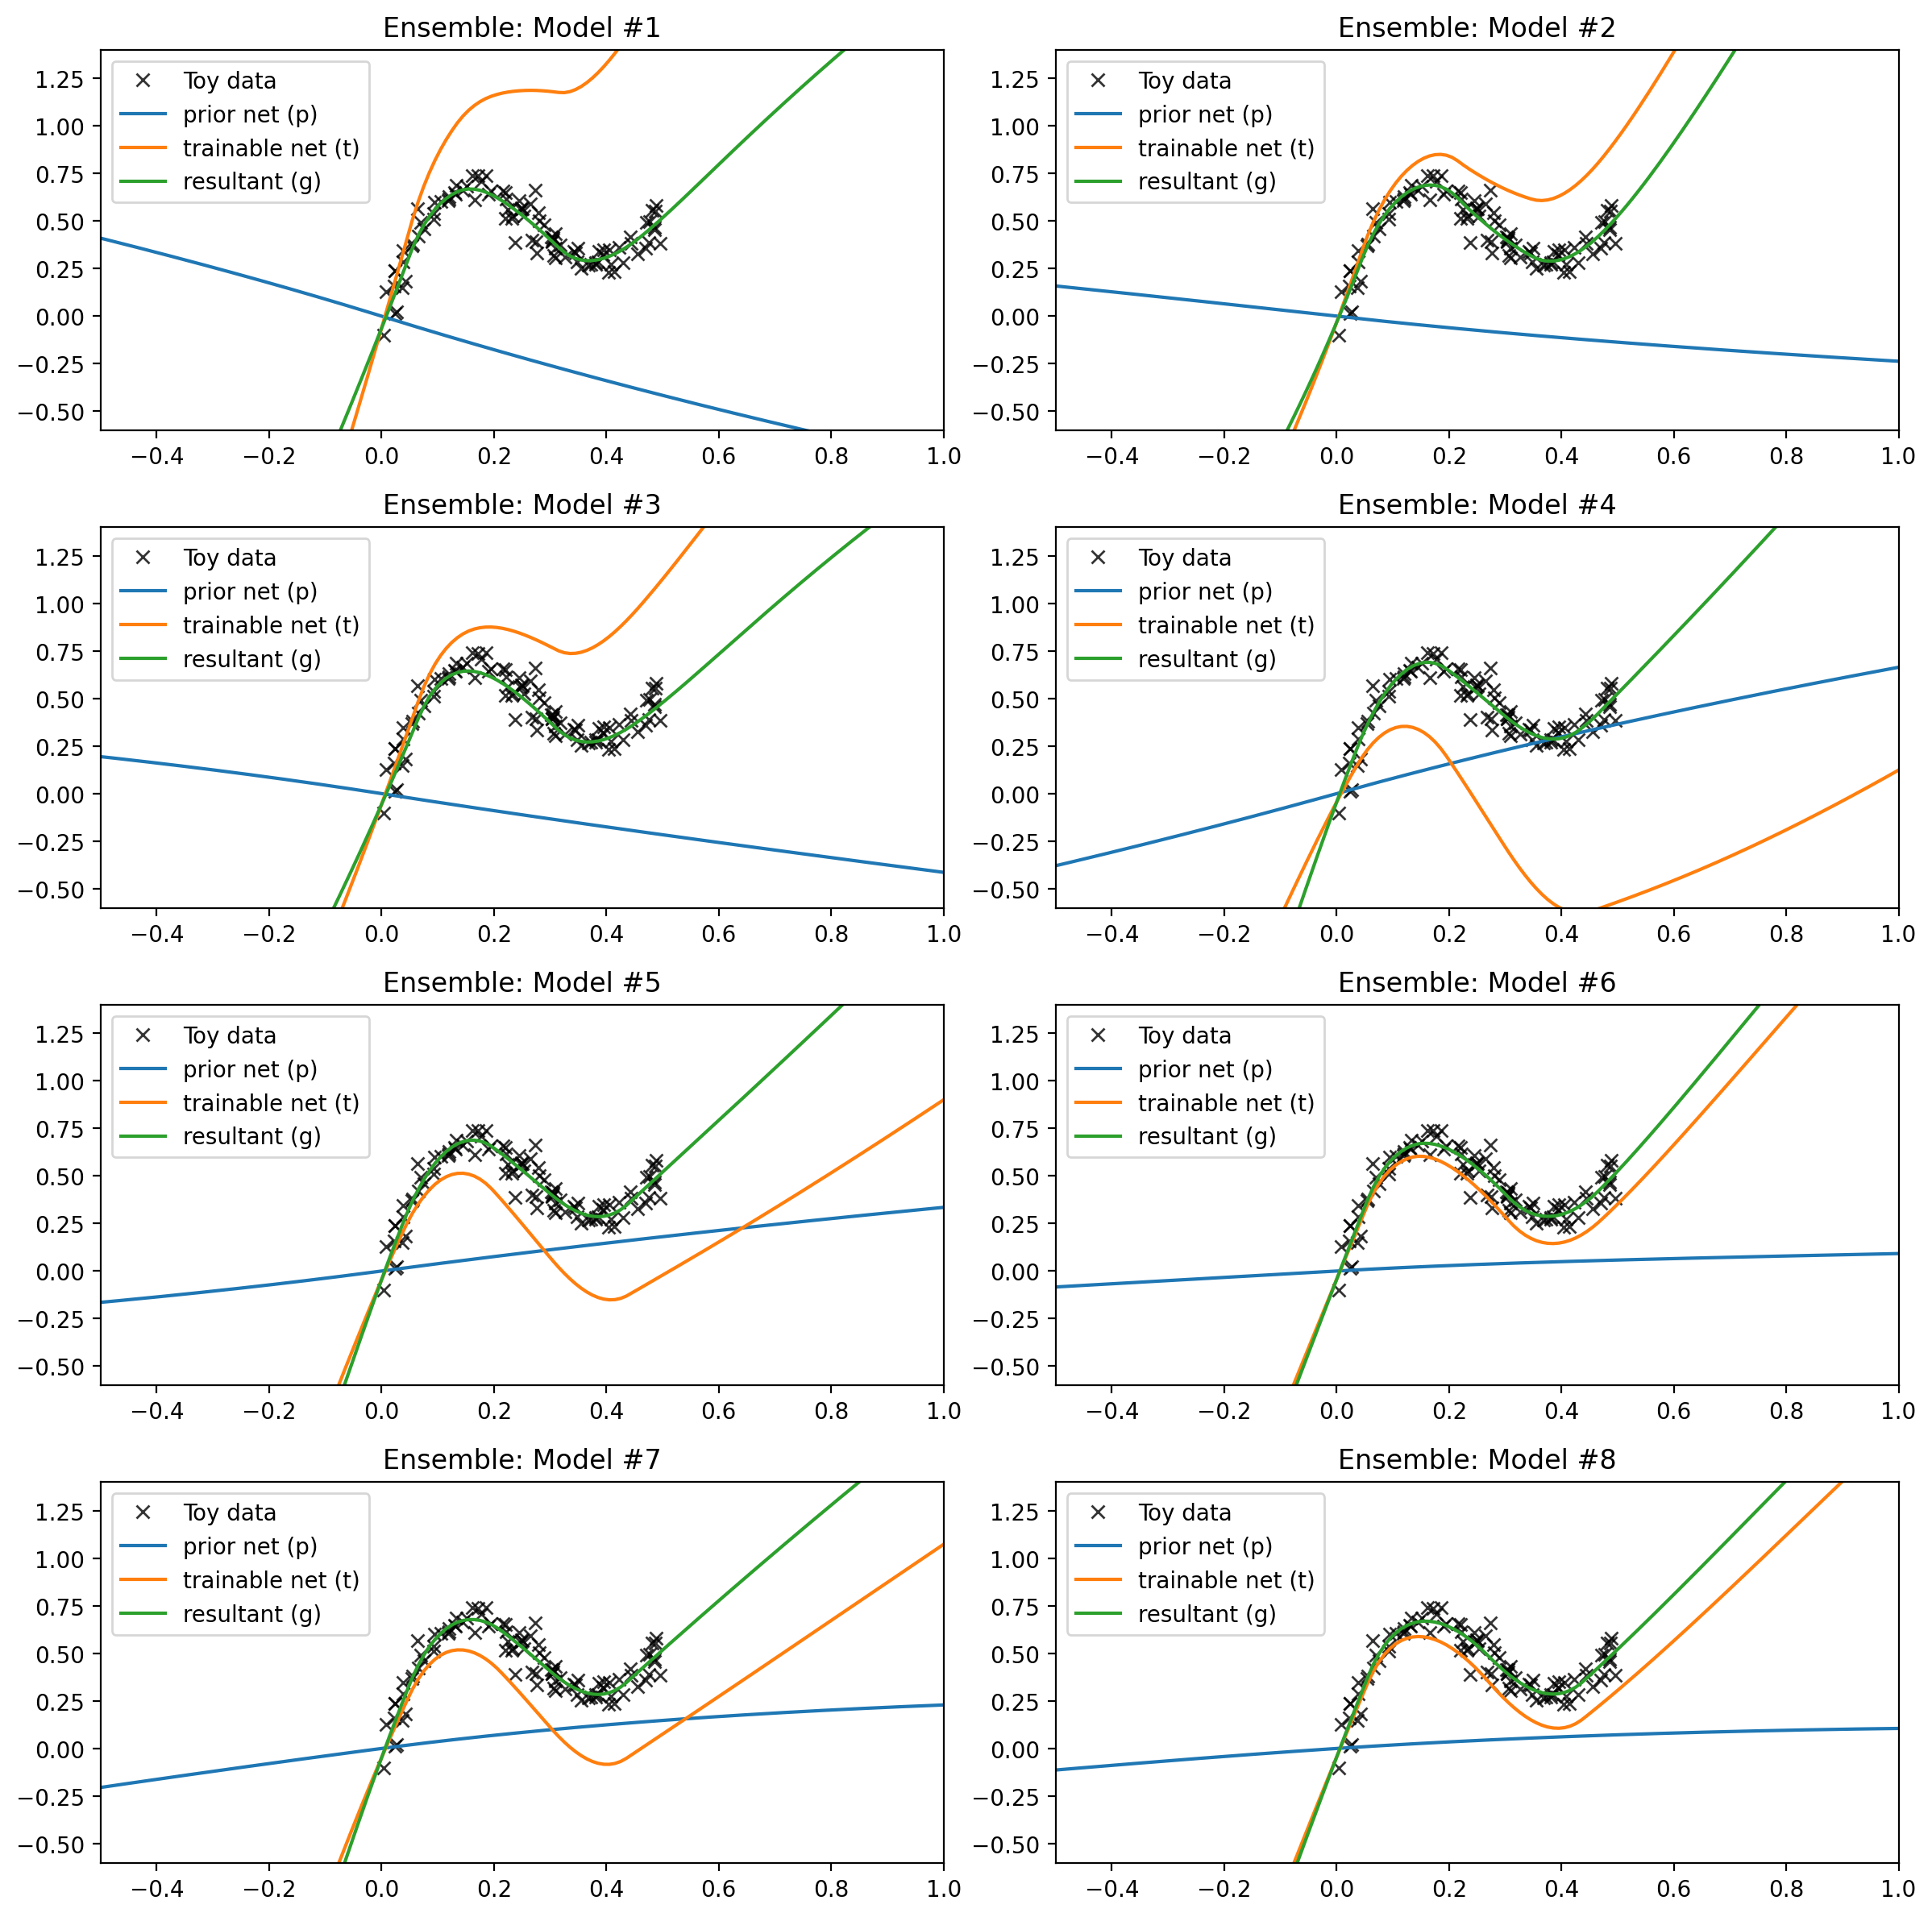

In [161]:
# Plot the results
plt.figure(figsize=[12,12], dpi=200)
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
    plt.plot(x_grid, p_grid[i,:,0], label='prior net (p)')
    plt.plot(x_grid, t_grid[i,:,0], label='trainable net (t)')
    plt.plot(x_grid, y_grid[i,:,0], label='resultant (g)')
    plt.title('Ensemble: Model #{}'.format(i+1))
    #plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.xlim(-0.5,1.0); plt.ylim(-0.6,1.4)
    #plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    plt.legend()

plt.tight_layout()

plt.savefig('randomized_priors_multi_model.pdf')  
plt.savefig('randomized_priors_multi_model.png') 
plt.show();

Let us go beyond the original Kaggle notebook and inspect that relationship between the weight of the prior, $\beta$ and the variance among the predictions of the ensembled models.

Intuitively, since the random priors are not trained, the variance should increase with $\beta$. Let us verify this visually.

In [ ]:
# Plot mean, std for various values of beta
def plot_mean_std_betas(n_estimators, betas, X, Y, X_new, epochs):
    res = [get_ensemble_predictions(n_estimators, beta, X, Y, x_grid, epochs) 
           for beta in betas]
    means = [grids[2].mean(axis=0)[:,0] for grids in res]
    stds = [grids[2].std(axis=0)[:,0] for grids in res]
    fig = plt.figure(figsize=[12, len(betas)*3], dpi=150)
    fig.suptitle('Uncertainty estimates given by bootstrapped ensemble of '
                 'neural networks with randomized priors', 
                 verticalalignment='center')
    for i, beta in enumerate(betas):
        # Plot predictive mean and std (left graph)
        plt.subplot(len(betas), 2, 2*i+1)
        plt.plot(X, Y, 'kx', label='Toy data')
        plt.title(f'Mean and Deviation for beta={beta}', fontsize=12)
        plt.xlim(-0.5, 1.0); plt.ylim(-2, 2)
        plt.legend()
        plt.plot(X_new, means[i], 'r--', linewidth=1.5)
        plt.fill_between(X_new.reshape(1,-1)[0], means[i] - stds[i], 
                         means[i] + stds[i], alpha=0.5, color='red')
        plt.fill_between(X_new.reshape(1,-1)[0], means[i] + 2*stds[i], 
                         means[i] - 2*stds[i], alpha=0.2, color='red')
        
        # Plot means of each net in ensemble (right graph)
        plt.subplot(len(betas), 2, 2*i+2)
        plt.plot(X, Y, 'kx', label='Toy data')
        plt.title(f'Samples for beta={beta}', fontsize=12)
        plt.xlim(-0.5, 1.0); plt.ylim(-1.5, 2)
        plt.legend() 
        for j in range(n_estimators):
            plt.plot(X_new, res[i][2][j,:,0], linestyle='--', linewidth=1.5)
    plt.show();


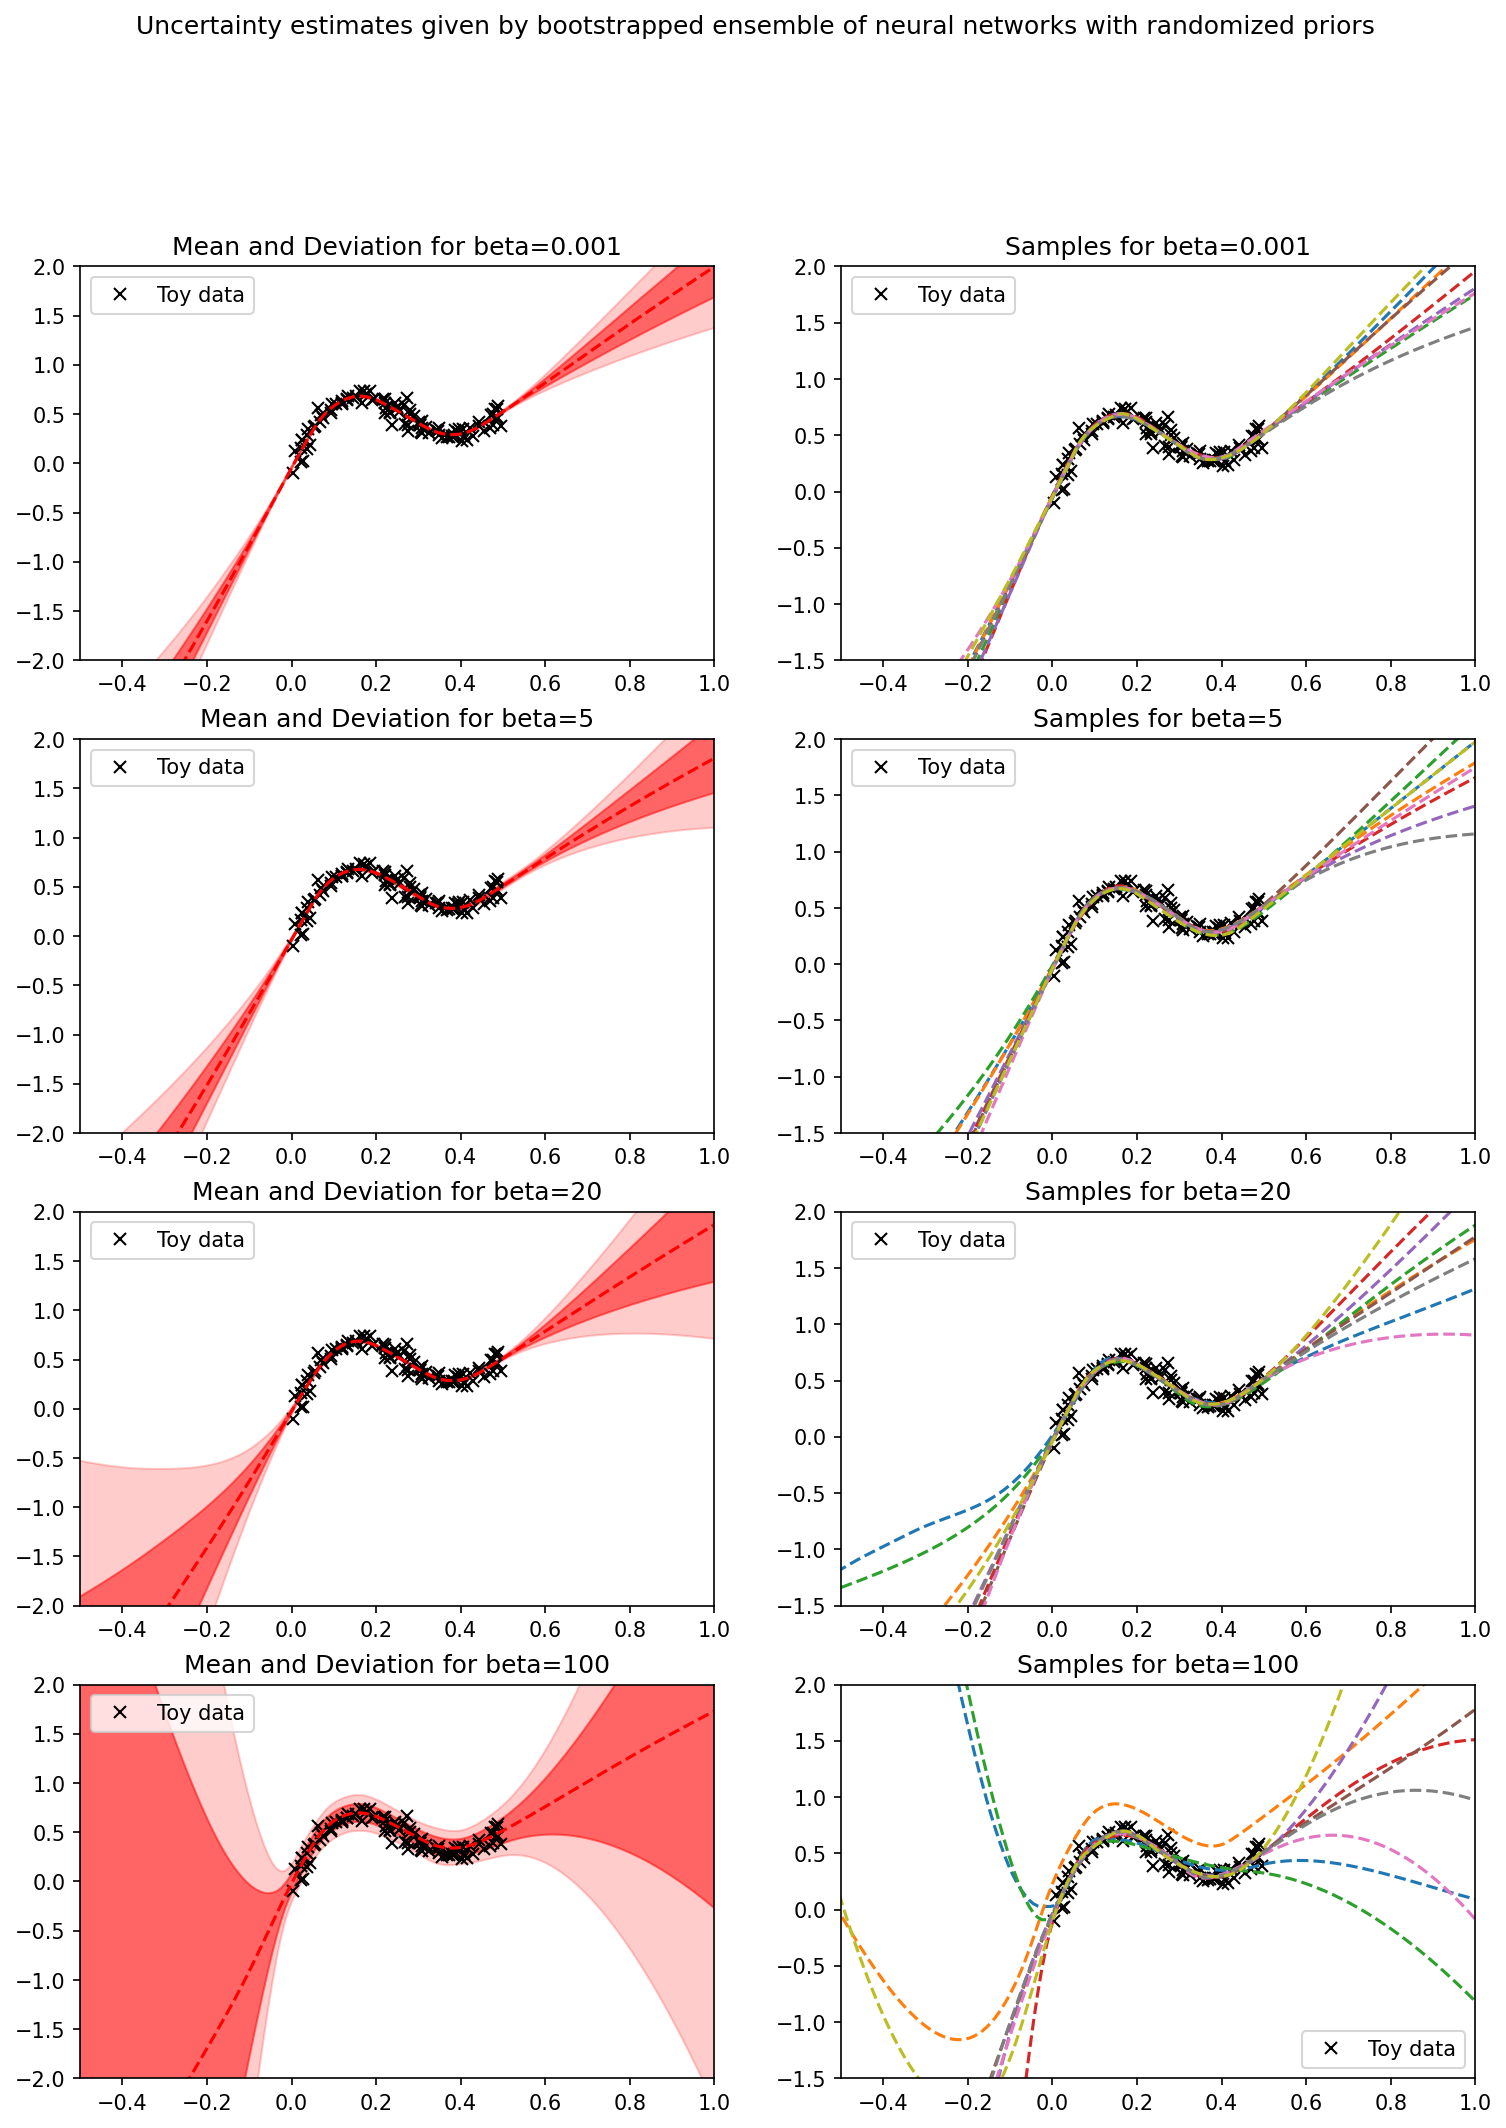

In [ ]:
# Choose a diverse selection of beta values
betas = [0.001, 5, 20, 100]
plot_mean_std_betas(9, betas, X, Y, x_grid, 3000)

# 4. Effects of Prior and Bootstrapping

Let us construct and compare the following four models:


1. Ensemble of nets **with** prior, **with** bootstrap (original model)
2. Ensemble of nets **with** prior, **without** bootstrap
3. Ensemble of nets **without** prior, **with** bootstrap
4. Ensemble of nets **without** prior, **without** bootstrap

Note that our previous constructions allow easy extensions into the three other model types. For nets without prior, we simply set ```beta=0``` (or, alternatively, use```GenericNet```) and for nets without bootstrap, we use the method ```get_ensemble_predictions(..., bootstrap=False)```.

In [ ]:
# With prior, with bootstrap (original)
*_, y_grid_1 = get_ensemble_predictions(9, 10, X, Y, x_grid, 3000)
# With prior, without bootstrap
*_, y_grid_2 = get_ensemble_predictions(9, 10, X, Y, x_grid, 3000, False)
# Without prior, with bootstrap
*_, y_grid_3 = get_ensemble_predictions(9, 0, X, Y, x_grid, 3000)
# Without prior, without bootstrap
*_, y_grid_4 = get_ensemble_predictions(9, 0, X, Y, x_grid, 3000, False)

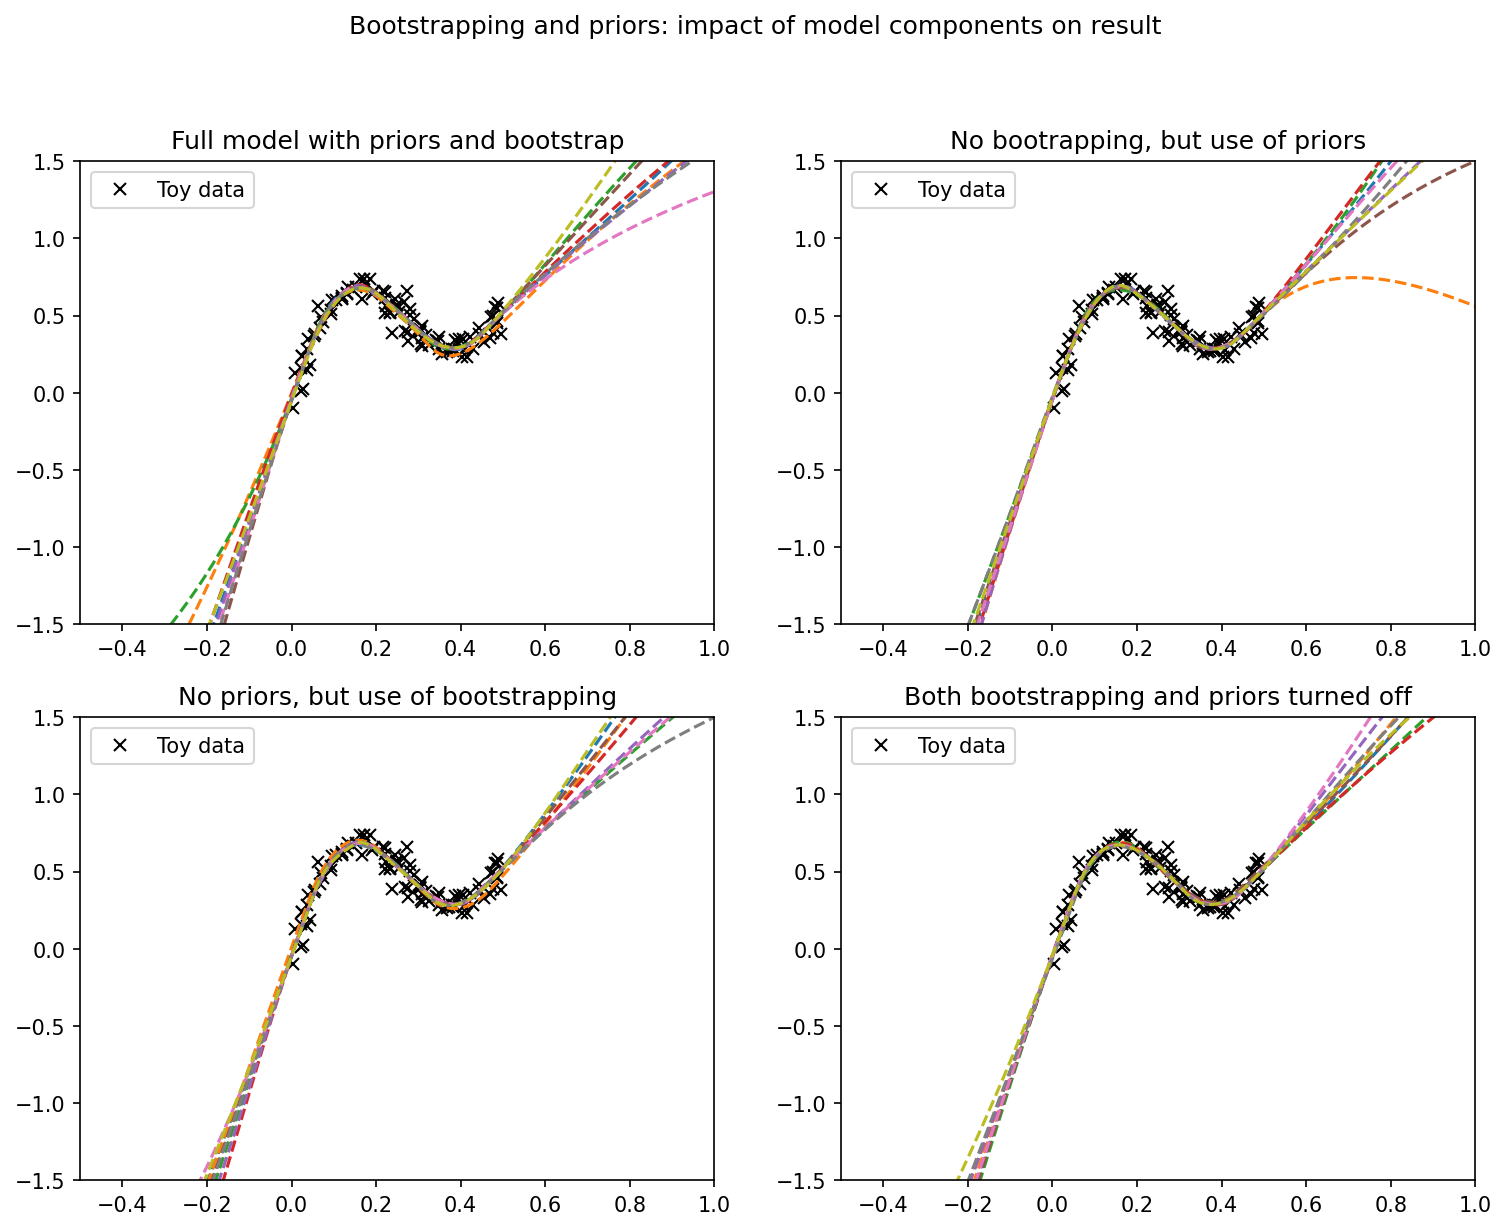

In [ ]:
# Plot the four types of models
fig = plt.figure(figsize=[12,9], dpi=150)
fig.suptitle('Bootstrapping and priors: impact of model components on result', 
             verticalalignment='center')

# With prior, with bootstrap
plt.subplot(2, 2, 1)
plt.plot(X, Y, 'kx', label='Toy data')
plt.title('Full model with priors and bootstrap', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-1.5, 1.5)
plt.legend() 
for i in range(9):
    plt.plot(x_grid, y_grid_1[i,:,0], linestyle='--', linewidth=1.5)

# With prior, without bootstrap
plt.subplot(2, 2, 2)
plt.plot(X, Y, 'kx', label='Toy data')
plt.title('No bootrapping, but use of priors', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-1.5, 1.5)
plt.legend() 
for i in range(9):
    plt.plot(x_grid, y_grid_2[i,:,0], linestyle='--', linewidth=1.5)

# Without prior, with bootstrap
plt.subplot(2, 2, 3)
plt.plot(X, Y, 'kx', label='Toy data')
plt.title('No priors, but use of bootstrapping', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-1.5, 1.5)
plt.legend()
for i in range(9):
    plt.plot(x_grid, y_grid_3[i,:,0], linestyle='--', linewidth=1.5)

# Without prior, without bootstrap
plt.subplot(2, 2, 4)
plt.plot(X, Y, 'kx', label='Toy data')
plt.title('Both bootstrapping and priors turned off', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-1.5, 1.5)
plt.legend()
for i in range(9):
    plt.plot(x_grid, y_grid_4[i,:,0], linestyle='--', linewidth=1.5)
    
# showing
plt.show();
